In [13]:
import sys; sys.path.append("../../wwa"); from wwa import *
from taylorDiagram import TaylorDiagram, taylor_scores

mapproj = cartopy.crs.PlateCarree()
Xn,Xx,Yn,Yx = [0,35,55,75]

ds_list = ["era5", "eobs", "cpc"]

def scale(ts): return (ts - ts.mean()) / ts.std()

# Seasonal cycle

## Stamp plots

In [ ]:
framing = "cordex"
varnm = "tasmin"
nc = 7

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# get obs SC

obs = merge_byindex([pd.read_csv("data/t"+varnm[-1]+"-fs-daily_"+ds_nm+".csv", index_col = 0, parse_dates = ["time"]) for ds_nm in ds_list]).loc[slice("1990","2020")]
obs.columns = ds_list
obs_sc = scale(obs).groupby(obs.index.dayofyear).mean()

# load model SC
fl = sorted(glob.glob("data/"+framing+"/"+varnm+"-sc*"))

# plot attributes
nmod = len(fl)
nr = int(np.ceil(nmod / nc))

days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(len(days)) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(len(days)) if (days[i].day) == 15]

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 5, nr * 3), dpi = 100, sharex = True, sharey = True)
plt.subplots_adjust(hspace = 0.3)

for i in range(len(fl)):
    ax = axs.flatten()[i]
    fnm = fl[i]
    sc = scale(xr.open_dataset(fnm)[varnm])

    obs_sc.plot(ax = ax)
    sc.plot(ax = ax, color = "k", label = "model")

    if framing == "cmip6":
        mdl = " ".join(fnm.split("_")[2:4])
    else:
        mdl = "_".join(fnm[:-3].split("_")[-3:])

    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(len(days)) if (days[x].day) == 1]
    ax.margins(x = 0)

    ax.set_title(mdl)
    ax.set_xlabel("")

for i in range(len(fl), nc*nr):  axs.flatten()[i].set_axis_off()

plt.savefig("mdl-eval/seasonal-cycle-scaled_"+varnm+"_"+framing)

## Taylor diagram

In [118]:
gcm_markers = {'ACCESS1-3_r1i1p1'             : 'o',
               'BCC-CSM1-1_r1i1p1'            : 'p',            
               'CanESM2_r1i1p1'               : 'h',
               'CCSM4_r1i1p1'                 : 'H',            
               'CESM1-BGC_r1i1p1'             : 's', 
               'CMCC-CM_r1i1p1'               : '>', 
               'GFDL-ESM2G_r1i1p1'            : 'd', 
               'MPI-ESM-MR_r1i1p1'            : '^',
               'MRI-CGCM3_r1i1p1'             : '<',
               'ERAINT_r1i1p1'                : '*',
               'CNRM-CM5_r1i1p1'              : 'o',
               'EC-EARTH_r12i1p1'             : 'p',
               'EC-EARTH_r1i1p1'              : 'h',
               'EC-EARTH_r3i1p1'              : 'H',
               'IPSL-CM5A-MR_r1i1p1'          : "s",
               'HadGEM2-ES_r1i1p1'            : 'P',
               'MIROC5_r1i1p1'                : '*',
               'MPI-ESM-LR_r1i1p1'            : '^',
               'MPI-ESM-LR_r2i1p1'            : '<',
               'MPI-ESM-LR_r3i1p1'            : '>',
               'NorESM1-M_r1i1p1'             : 'X'}

rcm_colours = {'ALADIN53'          : 'lightblue',
               'ALADIN63'          : 'mediumblue',
               'CCLM4-8-17'        : 'blueviolet',
               'COSMO-crCLIM-v1-1' : 'mediumvioletred',
               'HIRHAM5'           : 'red',
               'HadREM3-GA7-05'    : 'darkorange',
               'RACMO22E'          : 'gold',
               'RCA4'              : 'yellowgreen',
               'REMO2009'          : 'darkgreen',
               'REMO2015'          : 'green',
               'RegCM4-6'          : 'darkturquoise',
               'WRF361H'           : 'cadetblue',
               'WRF381P'           : 'dodgerblue'}

In [138]:
framing = "cordex"
varnm = "tasmax"

In [139]:
obs = [pd.read_csv("data/t"+varnm[-1]+"-fs-daily_"+ds_nm+".csv", index_col = 0, parse_dates = ["time"]).to_xarray() for ds_nm in ds_list]
obs = [da[list(da.data_vars)[0]].rename("tasmax").loc[slice("1990","2020")].groupby("time.dayofyear").mean() for da in obs]
obs = xr.concat(obs, "ds").assign_coords(ds = ds_list)

era5 = obs.sel(ds = "era5")

# load model SC
models = xr.concat([xr.open_dataset(fnm).expand_dims(run = ["_".join(fnm.split("_")[-3:])[:-3]]) for fnm in sorted(glob.glob("data/"+framing+"/"+varnm+"-sc*"))], "run")[varnm]

obs_corrs, obs_sds, ref_sd = taylor_scores(obs, era5)
mdl_corrs, mdl_sds, ref_sd = taylor_scores(models, era5)

res = pd.DataFrame.from_dict({"mdl" : models.run.values, "corr" : mdl_corrs, "sd" : mdl_sds}).set_index("mdl")
res.to_csv("mdl-eval/taylor-scores_"+varnm+"_cordex.csv")

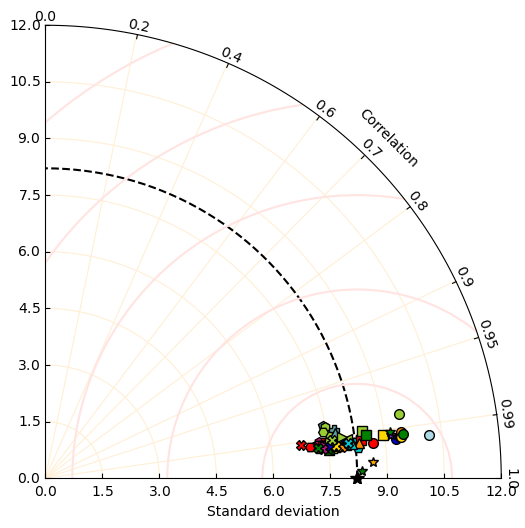

In [140]:
max_sd = {"tasmax" : 12, "tasmin" : 12}[varnm]
fig = plt.figure(figsize = (6,6), dpi= 100, facecolor='w', edgecolor='k')

# make Taylor diagram
td = TaylorDiagram(ref_sd, rect = 111, fig = fig, label = "ERA5", srange = (0, max_sd / ref_sd), extend = False)

td.add_contours(colors = "mistyrose") # lines of equal RMSE
td.add_grid(color = "papayawhip")  # lines of equal correlation & SD

# add other obs datasets
for i in range(1, len(obs)):
    td.add_sample(obs_sds[i], obs_corrs[i], marker = "*", ms = 7, ls = '', mfc = ["","green", "orange"][i], mec = "k", label = ds_list[i], zorder = 9)

# add models
for i in range(len(models)): 
    gcm,ens,rcm = models.run.values[i].split("_")
    gcm_marker = gcm_markers[gcm+"_"+ens]
    rcm_colour = rcm_colours[rcm]
    td.add_sample(mdl_sds[i], mdl_corrs[i], color = rcm_colour, marker = gcm_marker, ms = 7, ls = '', mec = "k", label = models.run.values[i], zorder = 9)

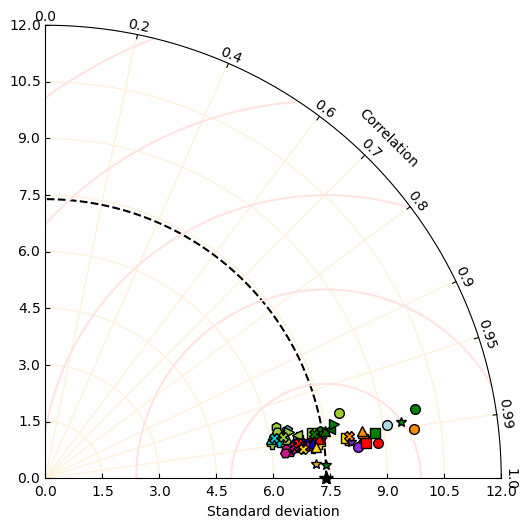


# Spatial pattern

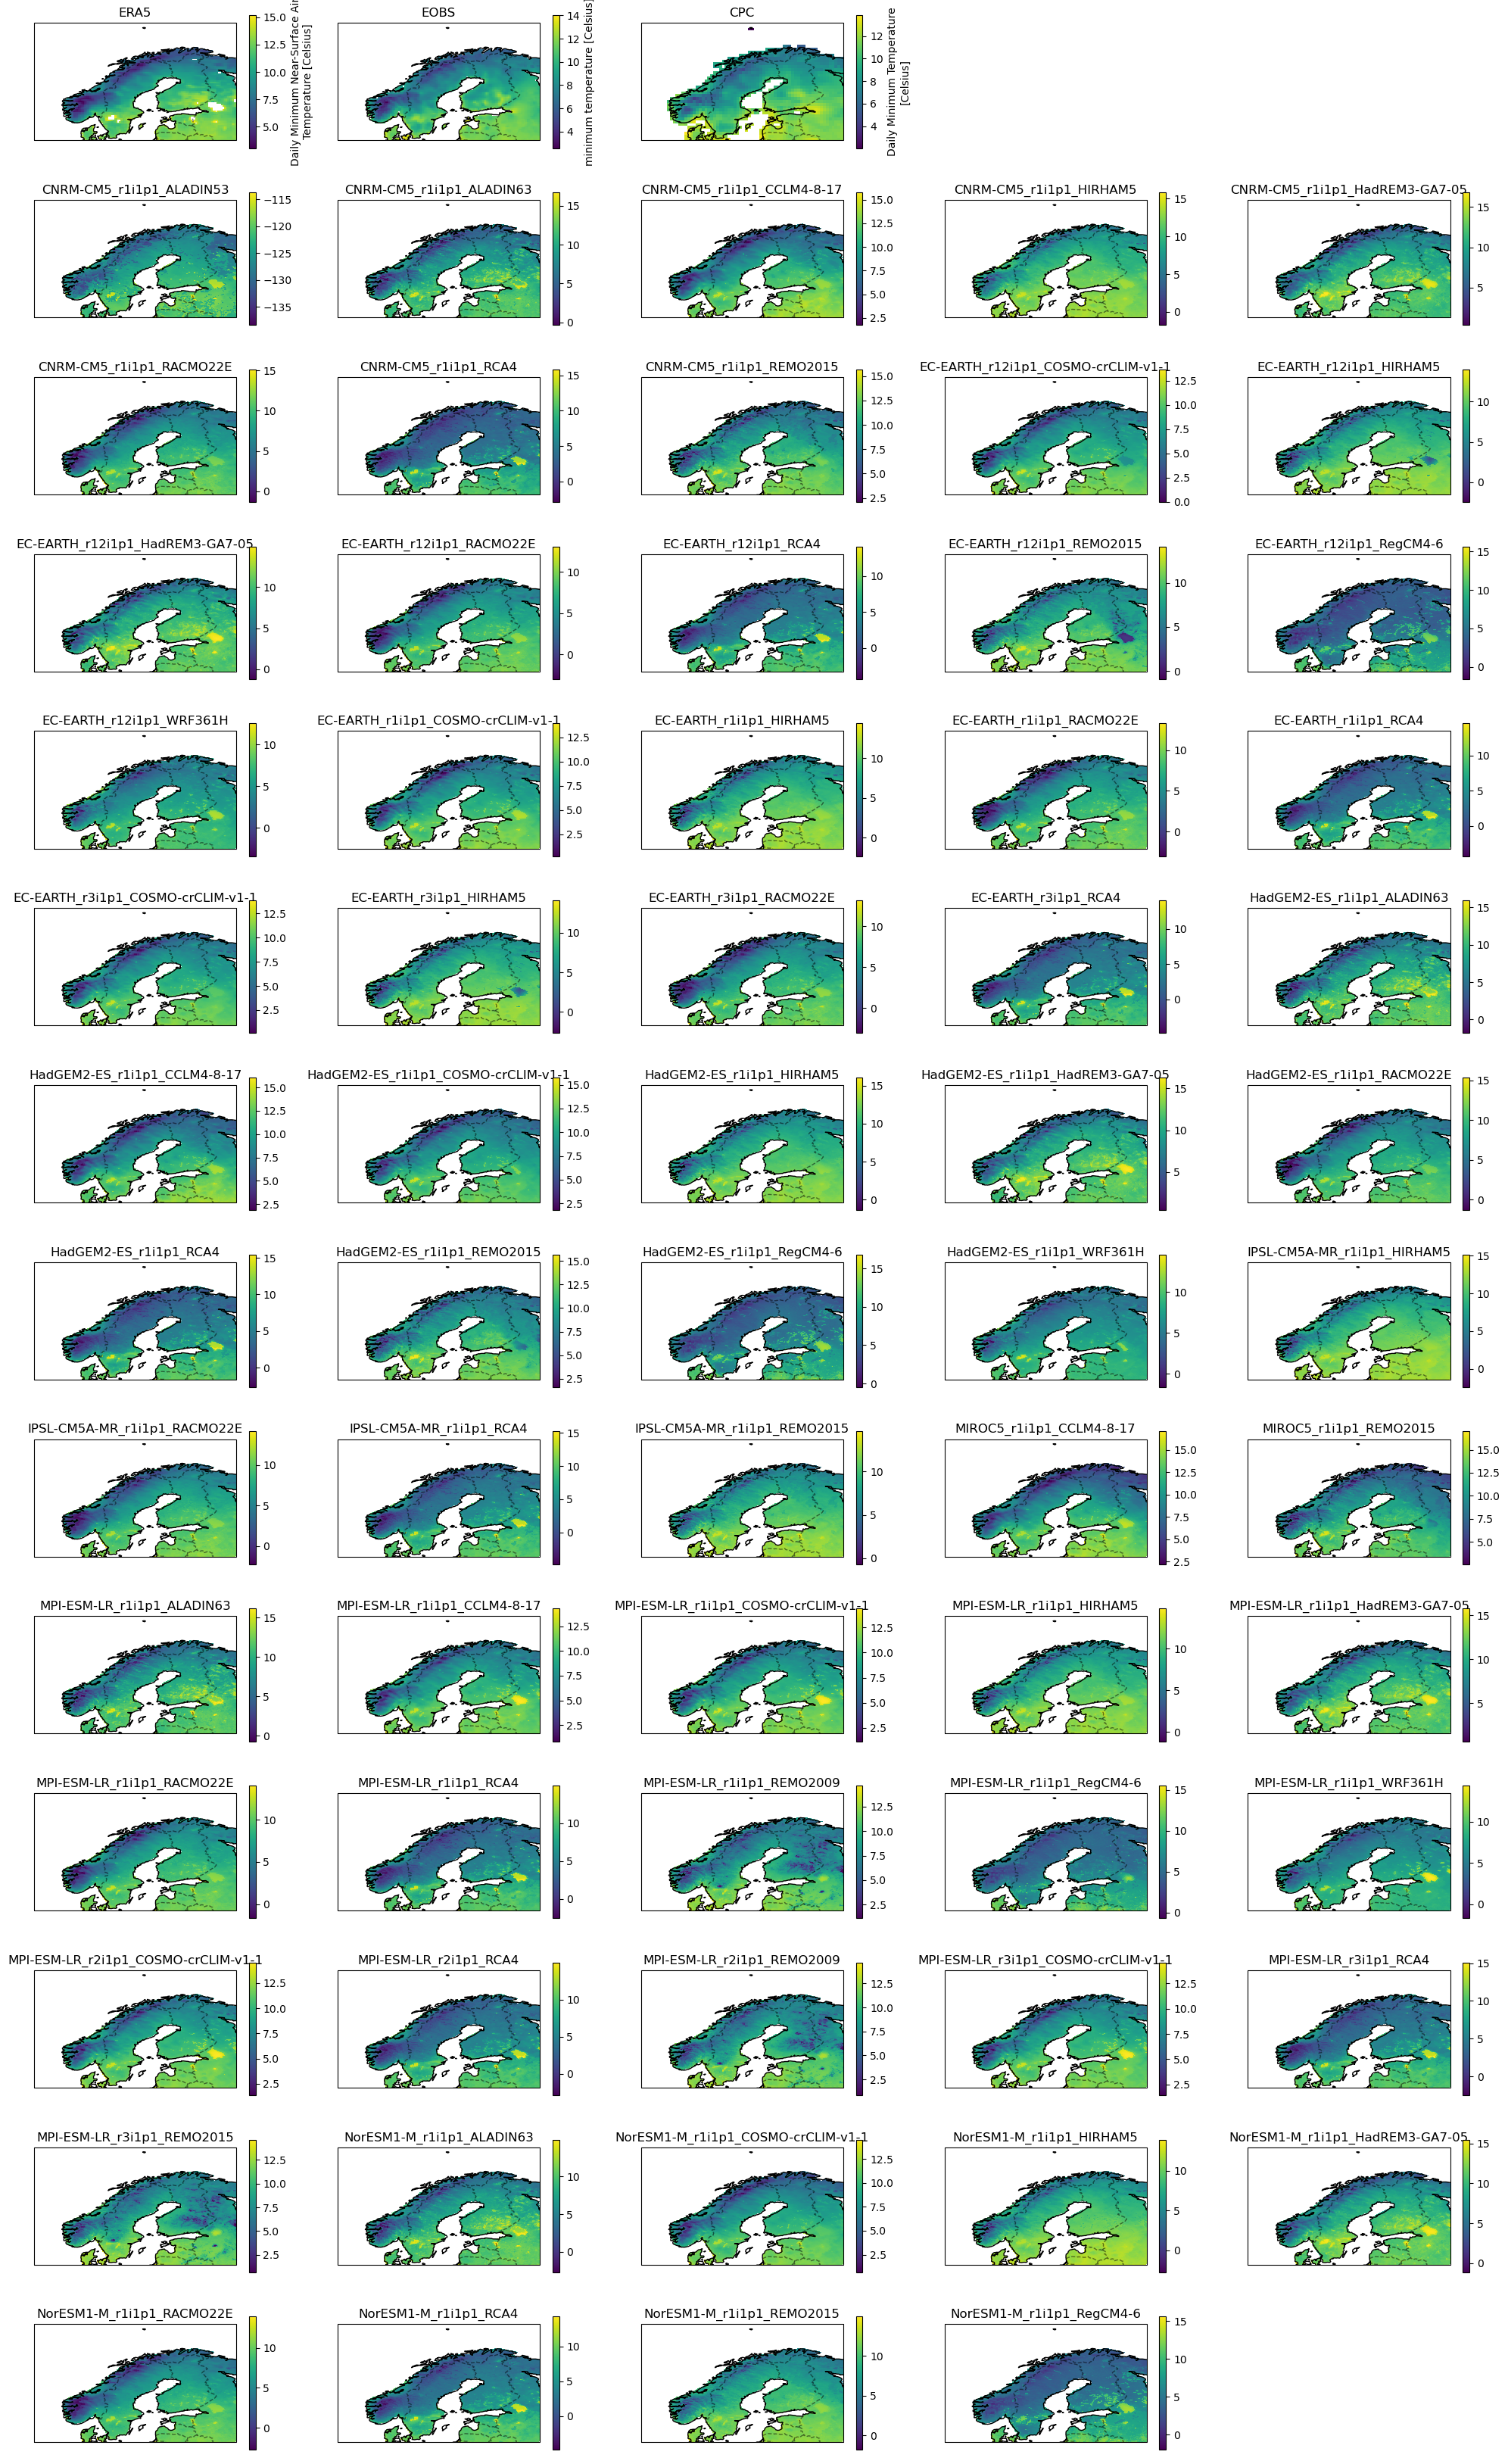

In [11]:
framing = "cordex"
varnm = "tasmin"
nc = 5


# list models & set up figures
fl = sorted(glob.glob("data/"+framing+"/"+varnm+"-sp*"))

# plot attributes
nmod = len(fl)
nr = int(np.ceil(nmod / nc))+1

cbar_kwargs = {"shrink" : 0.9}

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 5, nr * 3), dpi = 100, sharex = True, sharey = True, subplot_kw = {"projection" : mapproj, "extent" : (Xn,Xx,Yn,Yx)})
plt.subplots_adjust(hspace = 0.2)

for i in range(len(ds_list)):
    ds_nm = ds_list[i]
    ax = axs.flatten()[i]
    sp = xr.open_dataset("data/t"+varnm[-1]+"-sp_"+ds_nm+".nc")[varnm].sel(month = [6,7,8]).mean("month")
    sp.plot(ax = ax, cbar_kwargs = cbar_kwargs)
    ax.set_title(ds_nm.upper())
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
for i in range(len(ds_list),nc): axs.flatten()[i].set_axis_off()
    

for i in range(len(fl)):
    ax = axs.flatten()[nc+i]
    fnm = fl[i]

    sp = xr.open_dataset(fnm).sel(month = [6,7,8,]).mean("month")
    rm = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(sp.lon, sp.lat)
    
    if framing == "cmip6":
        mdl = " ".join(fnm.split("_")[2:4])
        sp.where(rm == 0).plot(ax = ax, cbar_kwargs = cbar_kwargs)
    else:
        mdl = "_".join(fnm[:-3].split("_")[-3:])
        cbar = ax.pcolormesh(sp.lon, sp.lat, sp[varnm].where(rm == 0))
        plt.colorbar(cbar, **cbar_kwargs)
        
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
    ax.set_title(mdl)
for i in range(len(fl)+nc, len(axs.flatten())): axs.flatten()[i].set_axis_off()
    
plt.savefig("fig/mdl-eval_spatial-pattern_"+varnm+"_"+framing)

## Ordered stamp plots (CORDEX)

In [184]:
framing = "cordex"
varnm = "tasmin"

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fl = sorted(glob.glob("data/"+framing+"/"+varnm+"-sp*"))

gcm_list = sorted(list(set(["_".join(fnm.split("_")[2:4]) for fnm in fl])))
rcm_list = sorted(list(set([fnm.split("_")[-1][:-3] for fnm in fl])))

nc = len(gcm_list)
nr = len(rcm_list)

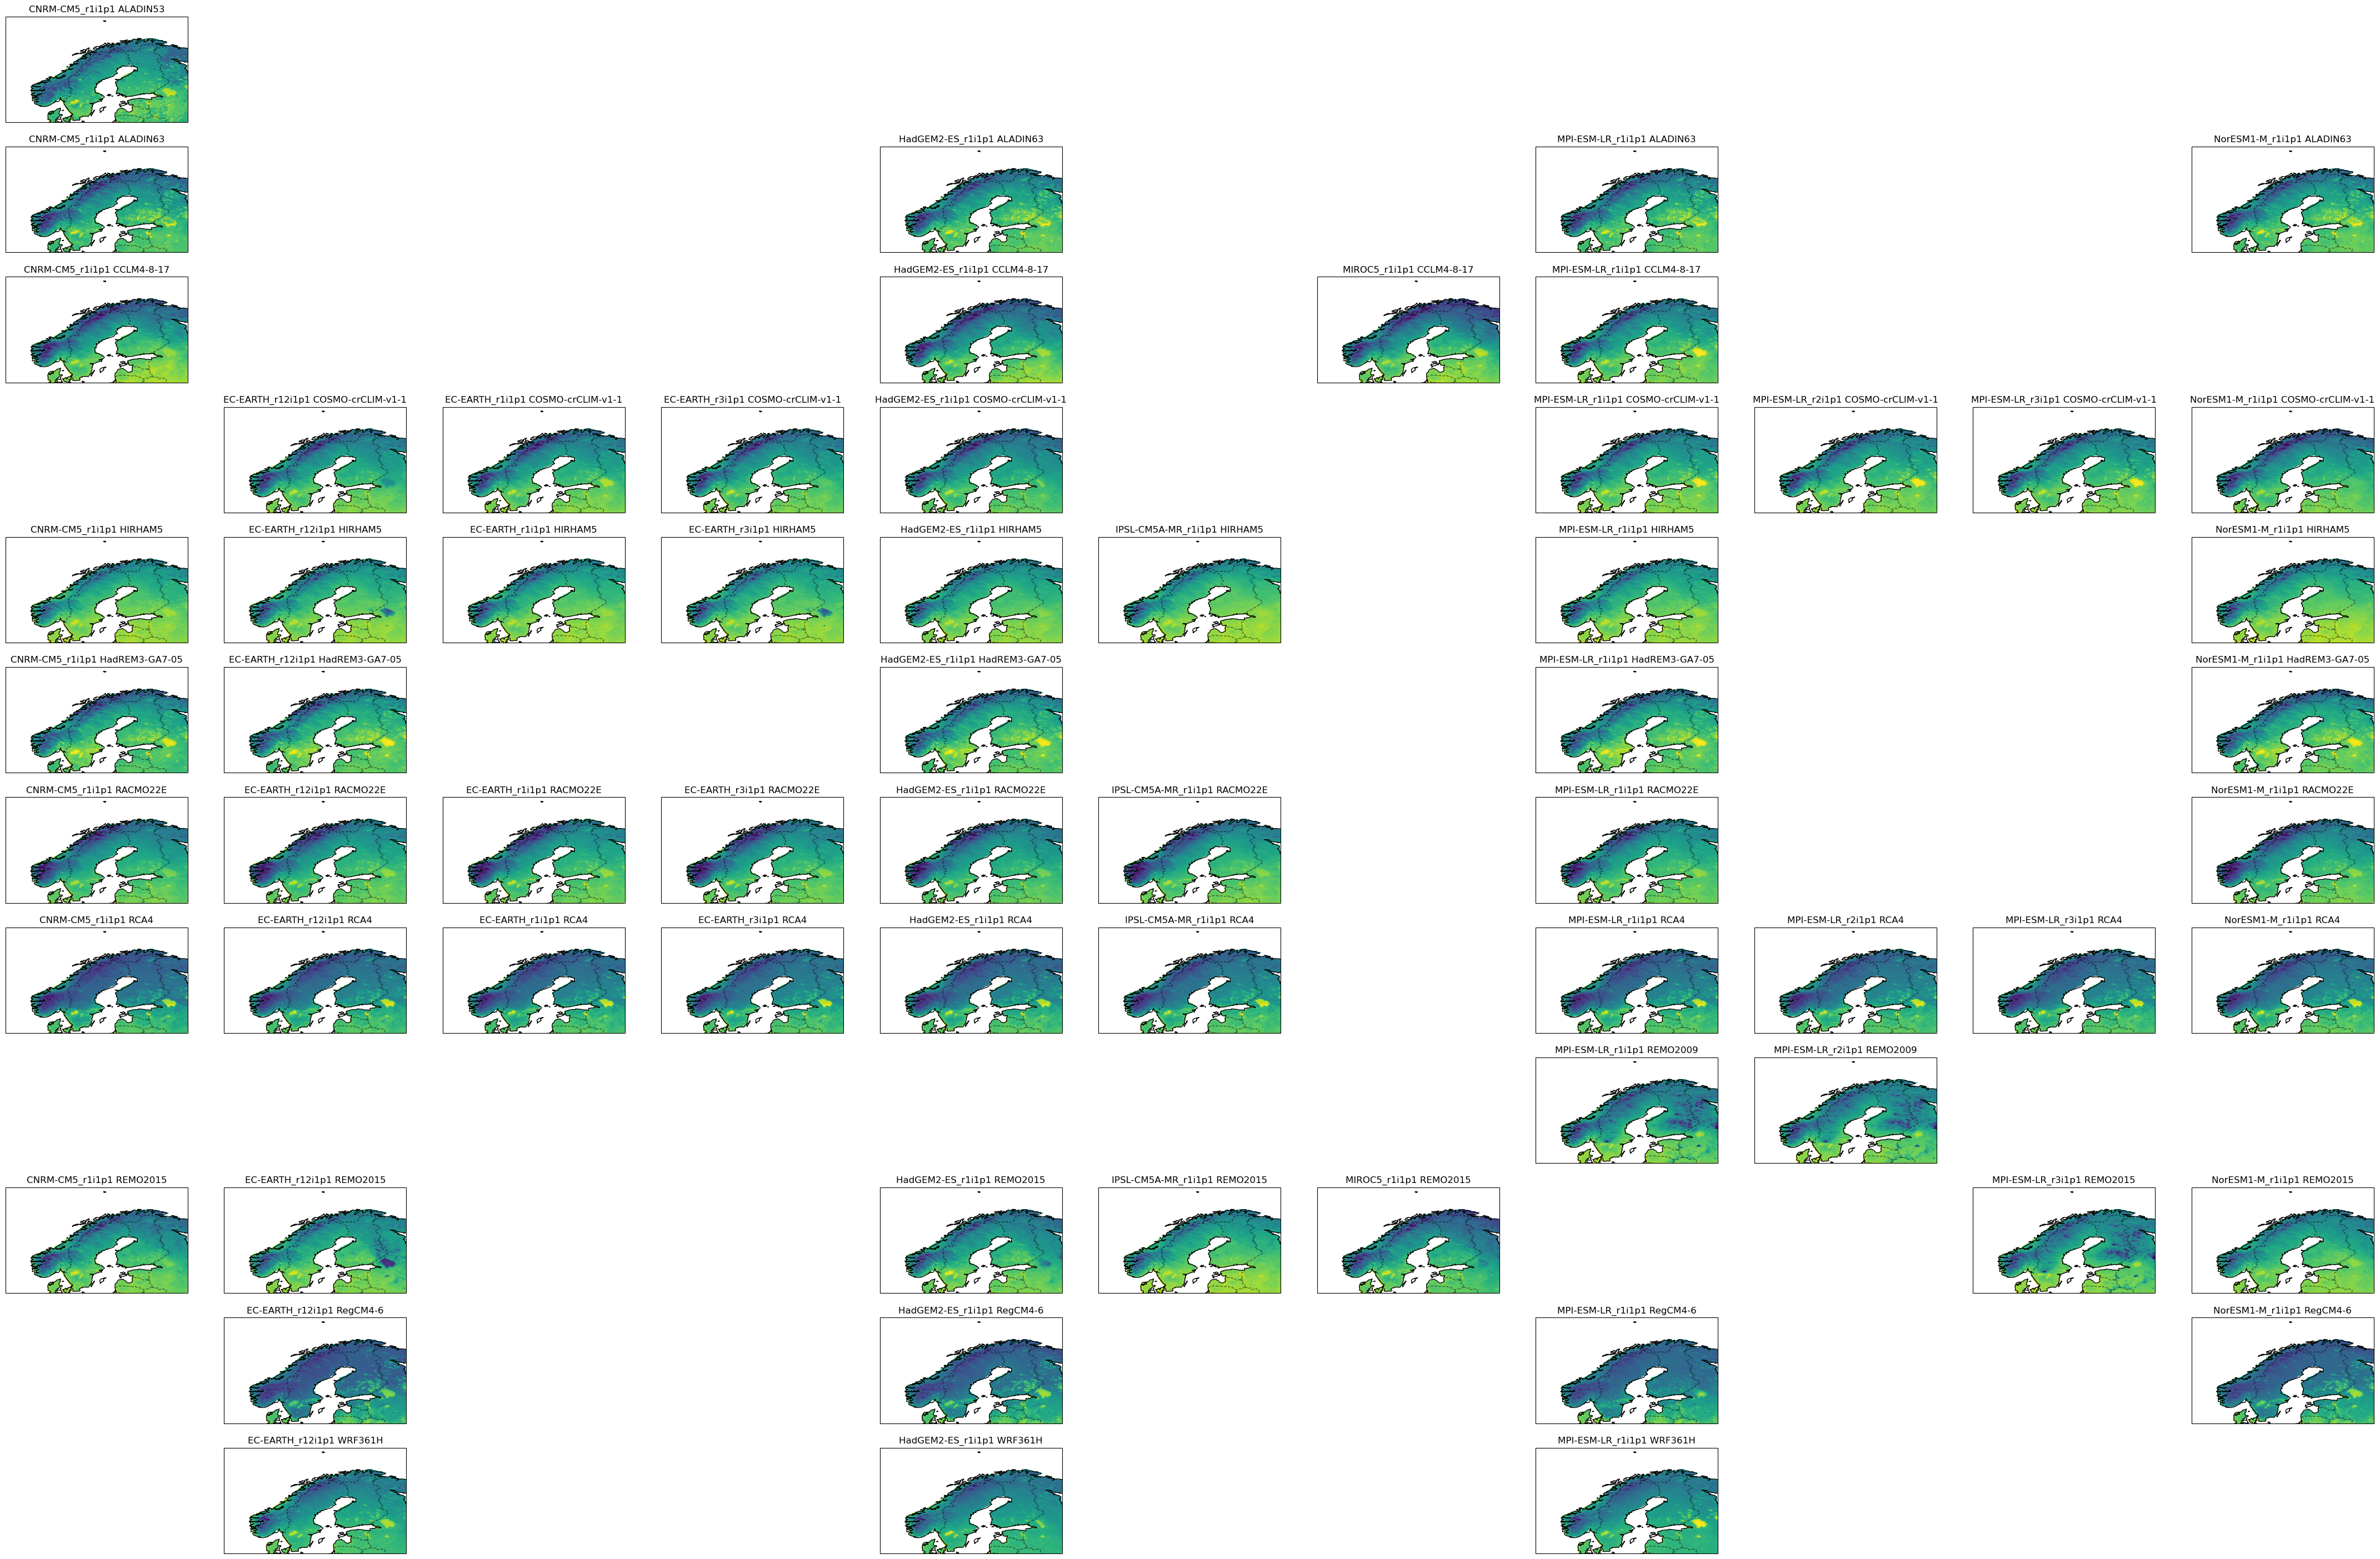

In [185]:
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 5, nr * 3), dpi = 100, sharex = True, sharey = True,
                        subplot_kw = {"projection" : mapproj, "extent" : (Xn,Xx,Yn,Yx)})
for ax in axs.flatten(): ax.set_axis_off()
    
for fnm in fl:
    gcm = "_".join(fnm.split("_")[2:4])
    rcm = fnm.split("_")[-1][:-3]

    j = gcm_list.index(gcm)
    i = rcm_list.index(rcm)
    ax = axs[i,j]

    sp = xr.open_dataset(fnm).sel(month = [6,7,8,]).mean("month")
    rm = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(sp.lon, sp.lat)
    ax.pcolormesh(sp.lon, sp.lat, sp[varnm].where(rm == 0))

    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
    ax.set_title(gcm+" "+rcm)
    
    ax.set_axis_on()
    
plt.savefig("fig/mdl-eval_spatial-pattern_"+varnm+"_"+framing+"-ordered")